# Deep Learning
=============


------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'

def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---

---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
folder = train_folders[0]
print ('folder=', folder)

for f in os.listdir(folder)[100:105]:
    f = os.path.join(folder, f)
    print(f)
    display(Image(filename=f))

folder= notMNIST_large/A
notMNIST_large/A/b25lOHNldmVuIDIuMC50dGY=.png


notMNIST_large/A/b25lOHNldmVuLnR0Zg==.png


notMNIST_large/A/b2lsLnR0Zg==.png


notMNIST_large/A/b2xkIHRpbWUgcmFkaW8udHRm.png


notMNIST_large/A/b3JhbmdlIHBob25lLnR0Zg==.png


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  image_index = 0
  print(folder)
  for image in os.listdir(folder):
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :] = image_data
      image_index += 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

---

---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

test_datasets ['notMNIST_small/A.pickle', 'notMNIST_small/B.pickle', 'notMNIST_small/C.pickle']
len(test_datasets)= 10 sample_fonts= [161, 1175, 567, 1184, 1321, 544, 325, 1585, 795, 953, 767, 340, 1427, 829, 1593, 515]
len(dataset)= 1872
len(dataset)= 1873
len(dataset)= 1873
len(dataset)= 1873
len(dataset)= 1873
len(dataset)= 1872
len(dataset)= 1872
len(dataset)= 1872
len(dataset)= 1872
len(dataset)= 1872


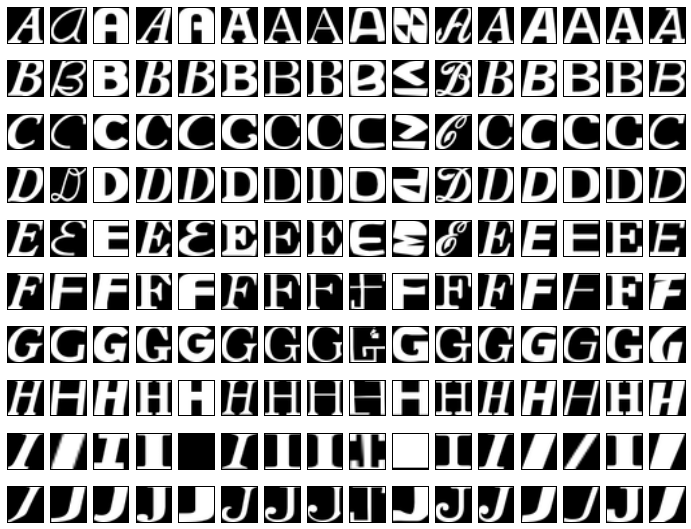

In [6]:
%matplotlib inline

print ("test_datasets", test_datasets[:3])

import matplotlib.pyplot as pl
import pickle
import random

n_col = 16
n_row = 10

pl.figure(figsize=(0.6 * n_col, 0.8 * n_row))
pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

index = 1
sample_fonts = random.sample(xrange(1800), n_col)
print ("len(test_datasets)=", len(test_datasets), "sample_fonts=", sample_fonts)
for folder in test_datasets[:n_row]:
    set_filename = folder
    dataset = pickle.load(file(set_filename))
    print("len(dataset)=", len(dataset))
    for col in range(n_col):
        n = sample_fonts[col]
        #print("n=", n)
        pl.subplot(n_row, n_col, index)
        pl.imshow(dataset[n], cmap=pl.cm.gray)
        pl.xticks(())
        pl.yticks(())
        index += 1

pl.show()   

---

---------
Another check: we expect the data to be balanced across classes. Verify that.

---

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [7]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [8]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  print("permutation len=", len(permutation))
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

permutation len= 200000
permutation len= 10000
permutation len= 10000


---

---------
Convince yourself that the data is still good after shuffling!

---

len(test_dataset)= 10000


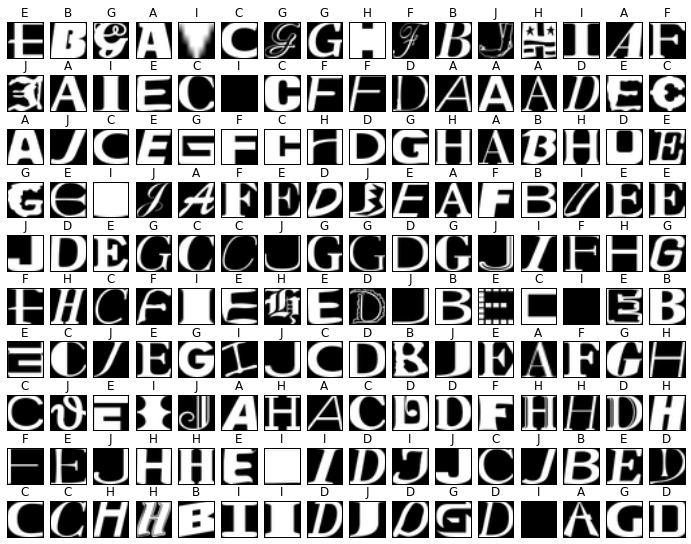

In [9]:
%matplotlib inline

#print ("test_dataset", test_dataset[:3])
#print ("test_labels", test_labels[:3])

import matplotlib.pyplot as pl
import pickle
import random

n_col = 16
n_row = 10
n_total = n_col * n_row

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
pl.figure(figsize=(0.6 * n_col, 0.8 * n_row))
pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

indexs = random.sample(xrange(len(test_dataset)), n_total)
#print("indexs=", indexs)
# sample_fonts = random.sample(xrange(1800), n_col)
print ("len(test_dataset)=", len(test_dataset))  #, "fonts=", fonts)
for i in range(n_total):
    index = indexs[i]
    #print ("index=", index)
    pl.subplot(n_row, n_col, i+1)
    #print ("test_dataset[i][j]=", test_dataset[i][j])
    pl.imshow(test_dataset[index], cmap=pl.cm.gray)
    pl.title(letters[test_labels[index]], size=12)
    pl.xticks(())
    pl.yticks(())

pl.show()   

Finally, let's save the data for later reuse:

In [10]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [11]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800514


---

---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

---

---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def train(train_size = 50):
    reg = LogisticRegression()
    reg.fit(train_dataset[:train_size].reshape(-1, 28*28), train_labels[:train_size])
    global pred 
    pred = reg.predict(test_dataset.reshape(-1, 28*28))

    print ("accuracy_score:", (accuracy_score(test_labels, pred)))
    print (classification_report(test_labels, pred, target_names=letters))
    print (confusion_matrix(test_labels, pred, labels=range(len(letters))))
    

In [15]:
train(50)

accuracy_score: 0.509
             precision    recall  f1-score   support

          A       0.77      0.57      0.66      1000
          B       0.41      0.54      0.46      1000
          C       0.62      0.09      0.16      1000
          D       0.60      0.02      0.04      1000
          E       0.37      0.65      0.47      1000
          F       0.67      0.71      0.69      1000
          G       0.35      0.78      0.48      1000
          H       0.48      0.28      0.36      1000
          I       0.60      0.79      0.68      1000
          J       0.81      0.65      0.72      1000

avg / total       0.57      0.51      0.47     10000

[[572  67   2   7  24  39  37  62 165  25]
 [ 16 538   4   2 238  35  93  36  31   7]
 [  9   9  90   0  95  47 678  17  49   6]
 [ 13 468   4  21  65  15 366  11  20  17]
 [ 19   3  10   0 649 105  59  55  93   7]
 [  5   5   3   0 130 712  13  67  45  20]
 [ 30  30  16   2  47  29 778  20  42   6]
 [ 51 100  13   0 459  44  17 284  26 

In [16]:
train(100)

accuracy_score: 0.6966
             precision    recall  f1-score   support

          A       0.91      0.79      0.85      1000
          B       0.65      0.56      0.60      1000
          C       0.76      0.78      0.77      1000
          D       0.92      0.68      0.79      1000
          E       0.45      0.76      0.57      1000
          F       0.63      0.69      0.66      1000
          G       0.71      0.71      0.71      1000
          H       0.64      0.42      0.50      1000
          I       0.76      0.76      0.76      1000
          J       0.77      0.81      0.79      1000

avg / total       0.72      0.70      0.70     10000

[[786  22  14  12  17  20  12  72  19  26]
 [ 12 562   7  10 210  73  59  18  30  19]
 [  1  22 781   2  89  19  58  14   6   8]
 [  7 103  15 684  17  25  69   8  21  51]
 [ 10  25  42   0 761  90  19  20  18  15]
 [  3  10  16   4 174 695  10  55  19  14]
 [  4  31 124   9  44  39 707  12  11  19]
 [ 22  48  11   9 351  68  15 417  50

In [17]:
train(1000)

accuracy_score: 0.8333
             precision    recall  f1-score   support

          A       0.87      0.85      0.86      1000
          B       0.82      0.82      0.82      1000
          C       0.83      0.86      0.84      1000
          D       0.87      0.86      0.86      1000
          E       0.82      0.78      0.80      1000
          F       0.83      0.86      0.85      1000
          G       0.82      0.83      0.82      1000
          H       0.87      0.81      0.84      1000
          I       0.78      0.82      0.80      1000
          J       0.82      0.83      0.83      1000

avg / total       0.83      0.83      0.83     10000

[[852  12   6  12  18   8  10  47  12  23]
 [ 16 821  14  37  27  16  33   3  27   6]
 [  5   9 859   9  29  17  40   5  17  10]
 [  7  37  16 862   7   8  16   6  18  23]
 [  7  35  43  10 784  22  17  12  57  13]
 [ 11   7  15   8  33 863  16  10  13  24]
 [ 15  19  44  23  11  30 827   6  14  11]
 [ 33  21  13   6  20  34  17 811  26

In [24]:
train(5000)

accuracy_score: 0.8511
             precision    recall  f1-score   support

          A       0.86      0.85      0.85      1000
          B       0.86      0.84      0.85      1000
          C       0.87      0.87      0.87      1000
          D       0.90      0.88      0.89      1000
          E       0.86      0.80      0.83      1000
          F       0.85      0.88      0.87      1000
          G       0.86      0.86      0.86      1000
          H       0.87      0.84      0.85      1000
          I       0.77      0.84      0.81      1000
          J       0.82      0.85      0.84      1000

avg / total       0.85      0.85      0.85     10000

[[846  16   5   5  12  13  17  48  17  21]
 [ 10 838   9  37  24  14  17  10  32   9]
 [  6   8 872   3  26  16  36   3  25   5]
 [ 12  14  14 881  11   9  12   8  12  27]
 [ 12  29  32   6 799  25  12  15  59  11]
 [ 14  19   5   5  16 883   9   6  24  19]
 [ 13  16  22  16  14  16 865   8  15  15]
 [ 33  14   8   8  15  27  15 836  23

test_dataset.shape= (10000, 28, 28)
len(test_dataset)= 10000


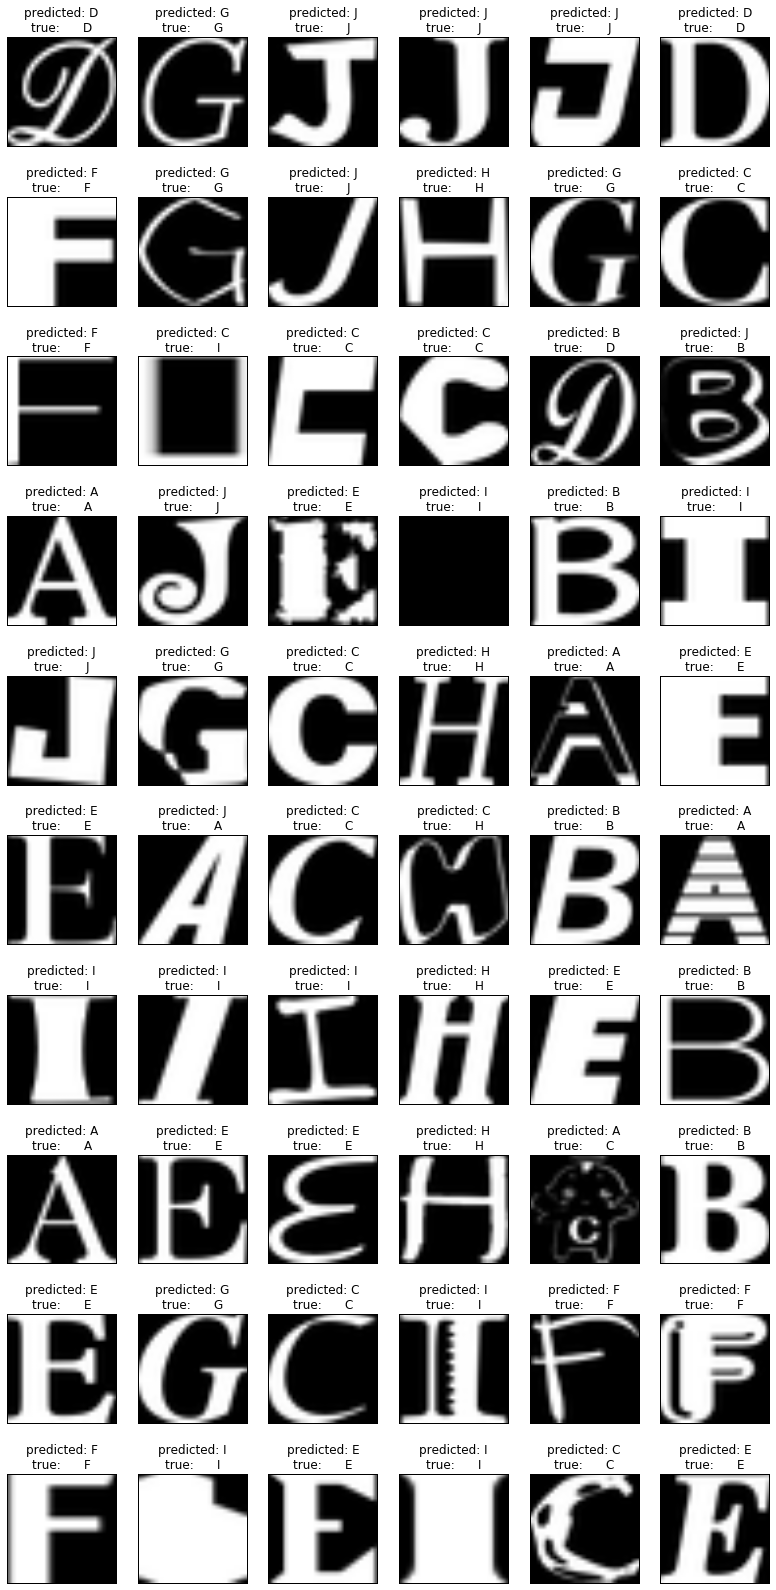

60


In [25]:
%matplotlib inline

n_col = 6
n_row = 10
n_total = n_col * n_row

indexs = random.sample(xrange(len(test_dataset)), n_total)
#print("indexs=", indexs)

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[indexs[i]]]
    true_name = target_names[y_test[indexs[i]]]
    #print("i=", i," y_pred=", y_pred[i], " y_test=", y_test[i])
    #print("pred_name=", pred_name, " true_name=", true_name)
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(pred, test_labels, letters, i)
                         for i in range(n_total)]


pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

print("test_dataset.shape=",  test_dataset.shape)
print ("len(test_dataset)=", len(test_dataset))  #, "fonts=", fonts)
for i in range(n_total):
    index = indexs[i]
    #print ("index=", index)
    pl.subplot(n_row, n_col, i+1)
    pl.imshow(test_dataset[index], cmap=pl.cm.gray)
    pl.title(prediction_titles[i], size=12)
    pl.xticks(())
    pl.yticks(())

pl.show()   
print (len(prediction_titles))